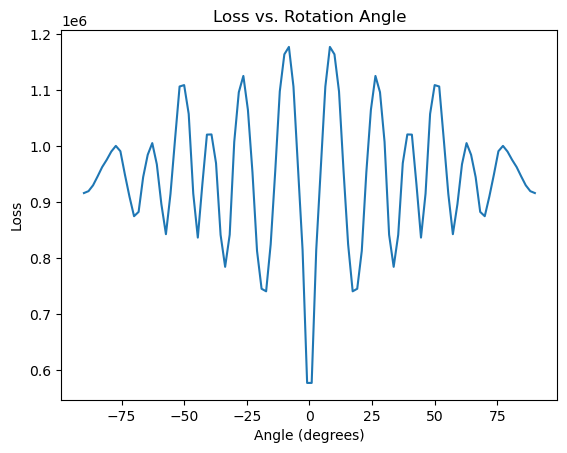

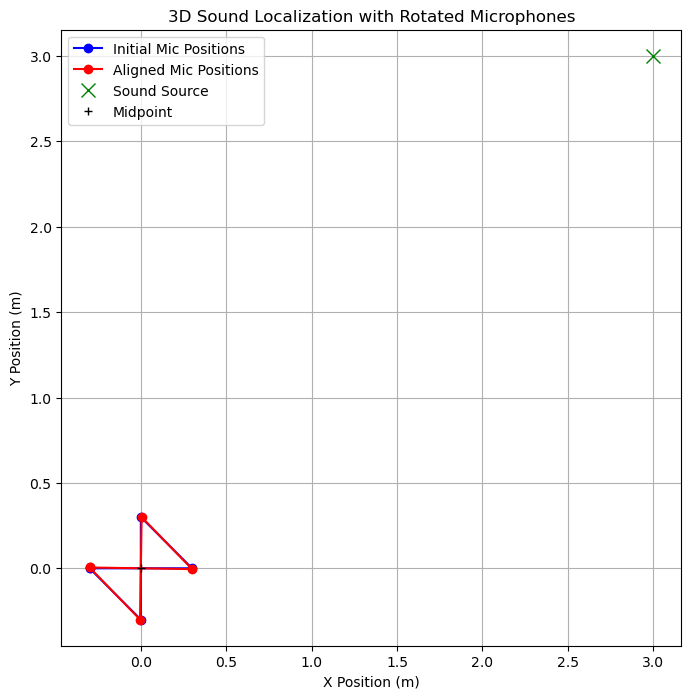

Optimal Angle (degrees): -0.9090909090909057
Rotated Microphone Positions:
Mic 1: [-0.29996224  0.00475979]
Mic 2: [ 0.29996224 -0.00475979]
Mic 3: [0.00475979 0.29996224]
Mic 4: [-0.00475979 -0.29996224]


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram, sosfilt, butter
from IPython.display import Audio

# Microphone positions
mic1_initial = np.array([-0.3, 0])   # Mic 1 position
mic2_initial = np.array([0.3, 0])    # Mic 2 position
mic3_initial = np.array([0, 0.3])    # Mic 3 position (above midpoint)
mic4_initial = np.array([0, -0.3])   # Mic 4 position (below midpoint)

# Sound source position
sound_source = np.array([3, 3])  # Initial sound source position

# Midpoint of the system
midpoint = np.array([0, 0])

# Function to rotate microphones and calculate alignment loss
def mic_rotation(angle_to_rotate, sound_source, midpoint):
    rotation_matrix = np.array([
        [np.cos(angle_to_rotate), -np.sin(angle_to_rotate)],
        [np.sin(angle_to_rotate), np.cos(angle_to_rotate)]
    ])

    mic1_rotated = midpoint + np.dot(rotation_matrix, mic1_initial - midpoint)
    mic2_rotated = midpoint + np.dot(rotation_matrix, mic2_initial - midpoint)
    mic3_rotated = midpoint + np.dot(rotation_matrix, mic3_initial - midpoint)
    mic4_rotated = midpoint + np.dot(rotation_matrix, mic4_initial - midpoint)

    return mic1_rotated, mic2_rotated, mic3_rotated, mic4_rotated

# Constants for loss calculation
SOUND_SPEED = 343.2

# Loss calculation function for a range of angles
def loss_angle(angle_to_rotate):
    mic1_rotated, mic2_rotated, mic3_rotated, mic4_rotated = mic_rotation(angle_to_rotate, sound_source, midpoint)

    dist_to_mic1 = np.linalg.norm(sound_source - mic1_rotated)
    dist_to_mic2 = np.linalg.norm(sound_source - mic2_rotated)
    dist_to_mic3 = np.linalg.norm(sound_source - mic3_rotated)
    dist_to_mic4 = np.linalg.norm(sound_source - mic4_rotated)

    t_to_mic1 = dist_to_mic1 / SOUND_SPEED
    t_to_mic2 = dist_to_mic2 / SOUND_SPEED
    t_to_mic3 = dist_to_mic3 / SOUND_SPEED
    t_to_mic4 = dist_to_mic4 / SOUND_SPEED

    samples_at_mic1 = int(t_to_mic1 * SR)
    samples_at_mic2 = int(t_to_mic2 * SR)
    samples_at_mic3 = int(t_to_mic3 * SR)
    samples_at_mic4 = int(t_to_mic4 * SR)

    min_samples = min(len(y) - samples_at_mic1, len(y) - samples_at_mic2, len(y) - samples_at_mic3, len(y) - samples_at_mic4)

    y1 = y[samples_at_mic1:samples_at_mic1 + min_samples]
    y2 = y[samples_at_mic2:samples_at_mic2 + min_samples]
    y3 = y[samples_at_mic3:samples_at_mic3 + min_samples]
    y4 = y[samples_at_mic4:samples_at_mic4 + min_samples]

    sos = butter(1, 500, 'lp', fs=SR, output='sos')
    y1 = sosfilt(sos, y1)
    y2 = sosfilt(sos, y2)
    y3 = sosfilt(sos, y3)
    y4 = sosfilt(sos, y4)

    # Calculate the loss as the sum of pairwise differences
    loss = (
        np.linalg.norm(y1 - y2) +
        np.linalg.norm(y2 - y3) +
        np.linalg.norm(y3 - y4) +
        np.linalg.norm(y4 - y1)
    )
    return loss

# Load audio file
folder_path = r'Bird_sound'
filename = "call1.wav"
file_path = os.path.join(folder_path, filename)

SR, y = wavfile.read(file_path)

# Calculate and plot loss for a range of angles
angles = np.linspace(-np.pi/2, np.pi/2, 100)
losses = np.array([loss_angle(a) for a in angles])

plt.figure()
plt.plot(np.degrees(angles), losses)
plt.xlabel("Angle (degrees)")
plt.ylabel("Loss")
plt.title("Loss vs. Rotation Angle")
plt.show()

# Display the final rotated microphone positions for the optimal angle
optimal_angle = angles[np.argmin(losses)]
mic1_rotated, mic2_rotated, mic3_rotated, mic4_rotated = mic_rotation(optimal_angle, sound_source, midpoint)

# Plotting the initial and aligned microphone positions
plt.figure(figsize=(8, 8))
plt.plot([mic1_initial[0], mic2_initial[0], mic3_initial[0], mic4_initial[0], mic1_initial[0]],
         [mic1_initial[1], mic2_initial[1], mic3_initial[1], mic4_initial[1], mic1_initial[1]], 'bo-', label="Initial Mic Positions")
plt.plot([mic1_rotated[0], mic2_rotated[0], mic3_rotated[0], mic4_rotated[0], mic1_rotated[0]],
         [mic1_rotated[1], mic2_rotated[1], mic3_rotated[1], mic4_rotated[1], mic1_rotated[1]], 'ro-', label="Aligned Mic Positions")
plt.plot(sound_source[0], sound_source[1], 'gx', label="Sound Source", markersize=10)
plt.plot(midpoint[0], midpoint[1], 'k+', label="Midpoint")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("3D Sound Localization with Rotated Microphones")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Display final microphone positions
print("Optimal Angle (degrees):", np.degrees(optimal_angle))
print("Rotated Microphone Positions:")
print("Mic 1:", mic1_rotated)
print("Mic 2:", mic2_rotated)
print("Mic 3:", mic3_rotated)
print("Mic 4:", mic4_rotated)
